# Supervised Spectral Unmixing with Landsat 8

This code will walk through the workflow process of arthur-e's github repo example: https://github.com/arthur-e/unmixing/blob/master/docs/Example_Spatially_Adaptive_Spectral_Mixture_Analysis_SASMA.ipynb

NOTE: This workflow requires cloning the above repo, activating your environment in the repo and `pip install -e`.  This is a very large file, so be prepared! 

The remainder of this notebook will also require a stacked Landsat 8 scene (see Landsat8-cropped-and-stacked.ipynb) and pre-determined spectral signatures.  In this example, I am using spectral signatures derived from an unsupervised classification using kmeans (see Kmean-Unsupervised-Classification.ipynb). 

In [5]:
# Import Packages
import os
from glob import glob

import geopandas as gpd
from shapely.geometry import box
import numpy as np
from matplotlib import pyplot as plt, cm
from matplotlib.colors import ListedColormap
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from unmixing.utils import as_array
from unmixing.utils import binary_mask
from unmixing.utils import subarray
from unmixing.lsma import FCLSAbundanceMapper
from unmixing.sasma import concat_endmember_arrays
from unmixing.transform import mnf_rotation
from unmixing.visualize import FeatureSpace

%matplotlib inline

# #######################NOT WORKING: INSISTING IT IS A .PY FILES###############
# # Make ONAQ site info retrievable
# %run ./kessb-NEON-scripts/data_grabber.ipynb

In [3]:
# Set working directory and other key paths
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

output_dir = os.path.join("data", "Landsat", "outputs")
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)
    
stacked_image_path = os.path.join(output_dir, 'stacked_aoi.tif')
unclassified_image_path = os.path.join(output_dir, 'classified_aoi.tif')

## Preparing unsupervised classification raster data

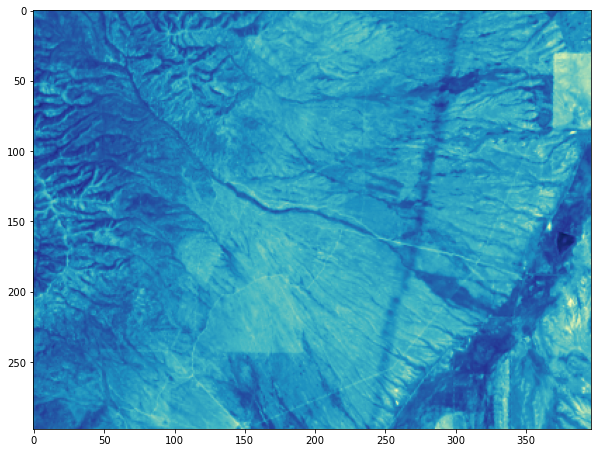

In [6]:
# Import stacked aoi and plot NIR band
stacked_arr, gt, wkt = as_array(stacked_image_path)

preview_nir = stacked_arr[3,...]
preview_nir[preview_nir == -9999] = 0 # Remap any NoData values to zero

# Reconfigure the raster array so that the band axis is the third axis
plt.figure(figsize = (10, 10))
plt.imshow(preview_nir, cmap = cm.YlGnBu_r)
plt.show()

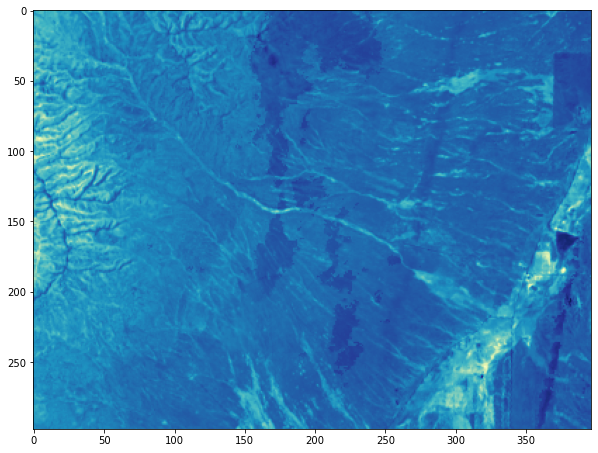

In [7]:
# Transform image to Minimum Noise Fraction (MNF)
#########PRIOR TO EXTRACTING ENDMEMBERS?  NEED TO DO PRE-CLASSIFICATION??????#########
mnf = mnf_rotation(lt5_detroit, nodata = -9999)

# The MNF image is returned in HSI form (the transpose of our original raster array)
plt.figure(figsize = (10, 10))
plt.imshow(mnf.T[0,...], cmap = cm.YlGnBu_r)
plt.show()

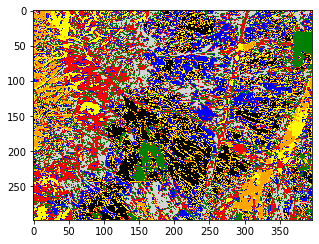

In [12]:
# Selecting endmembers from pre-defined spectral signatures
pifs, gt0, wkt0 = as_array(unclassified_image_path)

########################ONLY REFLECTING SINGLE CLASS#################################
# Create a color map for background (unclassified image used 7 classifiers)
color_code_map = ListedColormap(['lightgray', 
                                 'green', 
                                 'red', 
                                 'blue', 
                                 'yellow', 
                                 'orange', 
                                 'black'])
plt.figure(figsize = (5, 5))
plt.imshow(pifs[0,...], cmap = color_code_map)
plt.show()